## 1. Setup

In [192]:
# memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
# !pip install psutil
# !pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn # Base class for all neural network modules
tqdm.pandas(desc="Apply progress")
from tensorflow import nn

In [194]:
#mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install Google-Colab-Transfer

In [195]:
import colab_transfer

colab_path = colab_transfer.get_path_to_home_of_local_machine()
drive_path = colab_transfer.get_path_to_home_of_google_drive()

input_folder_name = ['w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch','w266: NLP Project/data/3days_by_hour/']

for name in input_folder_name:
  colab_transfer.copy_folder(
      folder_name=name,
      source=drive_path,
      destination=colab_path,
  )

Folder /content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch already exists. Copy skipped.
Folder /content/w266: NLP Project/data/3days_by_hour/ already exists. Copy skipped.


## 2. Building New Dataframe

In [7]:
from itertools import chain
df_train = pd.read_csv('/content/w266: NLP Project/data/3days_by_hour/train.csv')
train_input_ids = np.load('/content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/train_input_ids.npy')
train_true_labels = np.load('/content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/train_true_labels.npy', allow_pickle=True)
train_logit_array = np.load('/content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/train_logit_array.npy', allow_pickle=True)
train_finding_input_id = np.load('/content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/train_finding_input_id.npy', allow_pickle=True)

train_true_labels_big = np.array(list(chain.from_iterable(train_true_labels)))
train_logit_array_big = np.array(list(chain.from_iterable(train_logit_array)))
train_inputs_big = np.array(list(chain.from_iterable(train_finding_input_id)))

In [8]:
train_input_ids = train_input_ids.tolist()
train_inputs_big = train_inputs_big.tolist()

In [10]:
train_indices = []
for i in range(0,len(train_input_ids)):
  train_indices.append(train_input_ids.index(train_inputs_big[i]))

#Find how many duplicates there are, if there are <0.1% (52), it should be negligible to accuracy
len(train_indices) - len(set(train_indices))

7

In [11]:
from tensorflow import nn
train_results = pd.DataFrame({'ID': df_train.ID[train_indices], 'logits': train_logit_array_big.tolist(), 'Label': df_train.Label[train_indices]})
train_results['logit_diff'] = [x[1] - x[0] for x in train_results.logits]
train_results['prob_diff'] = [nn.sigmoid(x[1]).numpy() - nn.sigmoid(x[0]).numpy() for x in train_results.logits]
train_results = train_results.sort_index()

train_results.to_csv('/content/drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/df_train_results.csv')

In [12]:
train_grouped = train_results.groupby('ID').agg({'Label': 'mean', 'logit_diff': lambda x: list(x), 'prob_diff': lambda x: list(x)})
train_grouped.reset_index(level=0, inplace=True)

Mean length of array: 11.2 

Median length of array: 6.0 



Text(0.5, 1.0, 'Distribution of number of chunks per Admission ID')

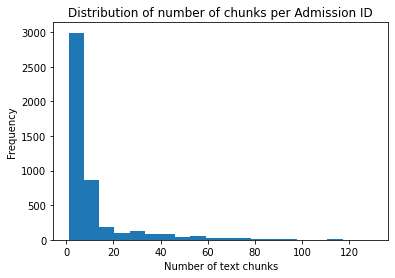

In [13]:
print("Mean length of array:", np.round(np.mean([len(i) for i in train_grouped.prob_diff]),1),'\n')
print("Median length of array:", np.round(np.median([len(i) for i in train_grouped.prob_diff]),0),'\n') #find the 
plt.hist([len(i) for i in train_grouped.prob_diff], bins=20)
plt.xlabel('Number of text chunks'); plt.ylabel('Frequency')
plt.title('Distribution of number of chunks per Admission ID')

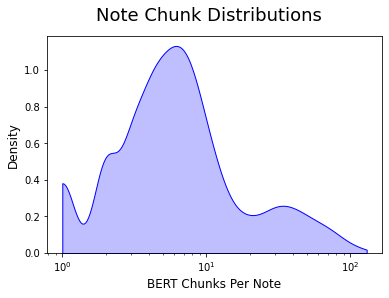

In [19]:
import seaborn as sns
fig = sns.kdeplot([len(i) for i in train_grouped.prob_diff], shade=True, color='b',cut =0, clip=(0,130), log_scale=True)
fig.figure.suptitle("Note Chunk Distributions", fontsize = 18)

plt.xlabel('BERT Chunks Per Note', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.savefig('/content/drive/MyDrive/w266: NLP Project/Paper/train_chunks.png')

In [20]:
#We decide to truncate/pad the difference arrays to 10, which is between the mean and median.
#We take the first 5 and last 5 values to truncate, and pad with 0
p_diff_pad = []
for i in train_grouped.prob_diff:
  if len(i) >= 10:
    p_diff_pad.append(i[0:5] + i[-5:])
  else:
    x = len(i)
    y = list(i)
    while x < 10:
      y.append(0)
      x = x + 1
    p_diff_pad.append(y)

l_diff_pad = []
for i in train_grouped.logit_diff:
  if len(i) >= 10:
    l_diff_pad.append(i[0:5] + i[-5:])
  else:
    x = len(i)
    y = list(i)
    while x < 10:
      y.append(0)
      x = x + 1
    l_diff_pad.append(y)

train_grouped['l_diff_pad'] = l_diff_pad
train_grouped['p_diff_pad'] = p_diff_pad
train_grouped.to_csv('/content/drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/df_train_grouped.csv')

In [199]:
#np.save('drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/l_diff_pad.npy', train_grouped.l_diff_pad)
#np.save('drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/p_diff_pad.npy', train_grouped.p_diff_pad)
l_diff_padding = np.load('drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/l_diff_pad.npy', allow_pickle= True)
p_diff_padding = np.load('drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/p_diff_pad.npy', allow_pickle= True)
train_grouped = pd.read_csv('drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/df_train_grouped.csv')
train_grouped['l_diff_pad'] = l_diff_padding
train_grouped['p_diff_pad'] = p_diff_padding

In [24]:
df_test = pd.read_csv('/content/w266: NLP Project/data/3days_by_hour/test.csv')
test_input_ids = np.load('/content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/test_input_ids.npy')
test_true_labels = np.load('/content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/test_true_labels.npy', allow_pickle=True)
test_logit_array = np.load('/content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/test_logit_array.npy', allow_pickle=True)
test_finding_input_id = np.load('/content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/test_finding_input_id.npy', allow_pickle=True)

test_true_labels_big = np.array(list(chain.from_iterable(test_true_labels)))
test_logit_array_big = np.array(list(chain.from_iterable(test_logit_array)))
test_inputs_big = np.array(list(chain.from_iterable(test_finding_input_id)))

test_input_ids = test_input_ids.tolist()
test_inputs_big = test_inputs_big.tolist()

test_indices = []
for i in range(0,len(test_input_ids)):
  test_indices.append(test_input_ids.index(test_inputs_big[i]))

test_results = pd.DataFrame({'ID': df_test.ID[test_indices], 'logits': test_logit_array_big.tolist(), 'Label': df_test.Label[test_indices]})
test_results['logit_diff'] = [x[1] - x[0] for x in test_results.logits]
test_results['prob_diff'] = [nn.sigmoid(x[1]).numpy() - nn.sigmoid(x[0]).numpy() for x in test_results.logits]
test_results = test_results.sort_index()

test_grouped = test_results.groupby('ID').agg({'Label': 'mean', 'logit_diff': lambda x: list(x), 'prob_diff': lambda x: list(x)})
test_grouped.reset_index(level=0, inplace=True)

p_diff_pad = []
for i in test_grouped.prob_diff:
  if len(i) >= 10:
    p_diff_pad.append(i[0:5] + i[-5:])
  else:
    x = len(i)
    y = list(i)
    while x < 10:
      y.append(0)
      x = x + 1
    p_diff_pad.append(y)

l_diff_pad = []
for i in test_grouped.logit_diff:
  if len(i) >= 10:
    l_diff_pad.append(i[0:5] + i[-5:])
  else:
    x = len(i)
    y = list(i)
    while x < 10:
      y.append(0)
      x = x + 1
    l_diff_pad.append(y)

test_grouped['l_diff_pad'] = l_diff_pad
test_grouped['p_diff_pad'] = p_diff_pad
test_grouped.to_csv('/content/drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/df_test_grouped.csv')
np.save('drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/l_diff_pad_test.npy', test_grouped.l_diff_pad)
np.save('drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/p_diff_pad_test.npy', test_grouped.p_diff_pad)

In [23]:
np.mean(test_grouped['Label'])

0.5

In [6]:
train_grouped = pd.read_csv('/content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/df_train_grouped.csv')
test_grouped = pd.read_csv('/content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/df_test_grouped.csv')

l_diff_pad_train = np.load('/content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/l_diff_pad.npy', allow_pickle=True)
p_diff_pad_train = np.load('/content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/p_diff_pad.npy', allow_pickle=True)
l_diff_pad_test = np.load('/content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/l_diff_pad_test.npy', allow_pickle=True)
p_diff_pad_test = np.load('/content/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/p_diff_pad_test.npy', allow_pickle=True)

train_grouped['l_diff_pad'] = l_diff_pad_train
train_grouped['p_diff_pad'] = p_diff_pad_train
test_grouped['l_diff_pad'] = l_diff_pad_test
test_grouped['p_diff_pad'] = p_diff_pad_test

## 3. Logistic Regression Base Model

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report


In [27]:
import warnings
warnings.filterwarnings("ignore")
grid={"C":np.append(np.logspace(-3,3,7),np.linspace(2e-2, 9e-2, 8)), "penalty":["l2"], "max_iter":[100,300,500]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(list(train_grouped.l_diff_pad), train_grouped.Label)
print("tuned hyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)
#warnings.filterwarnings("default")
#lr_model.score(list(train_grouped.l_diff_pad), train_grouped.Label)

tuned hyerparameters :(best parameters)  {'C': 1.0, 'max_iter': 100, 'penalty': 'l2'}
accuracy : 0.8361120223060523


In [28]:
import warnings
warnings.filterwarnings("ignore")
grid={"C":np.append(np.logspace(-3,3,7),np.linspace(2e-2, 9e-2, 8)), "penalty":["l2"], "max_iter":[100,300,500]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(list(train_grouped.p_diff_pad), train_grouped.Label)
print("tuned hyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)
#warnings.filterwarnings("default")
#lr_model.score(list(train_grouped.l_diff_pad), train_grouped.Label)

tuned hyerparameters :(best parameters)  {'C': 100.0, 'max_iter': 100, 'penalty': 'l2'}
accuracy : 0.8369658119658119


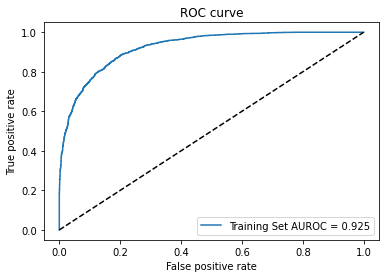

In [177]:
lr_model = LogisticRegression(random_state=0, C = 1).fit(list(train_grouped.l_diff_pad), train_grouped.Label)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = lr_model.predict_proba(list(train_grouped.l_diff_pad))
lr_fpr, lr_tpr, _ = roc_curve(train_grouped.Label, lr_probs[:,1])
auc_score = auc(lr_fpr, lr_tpr)
plt.plot(lr_fpr, lr_tpr, label='Training Set AUROC = {:.3f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

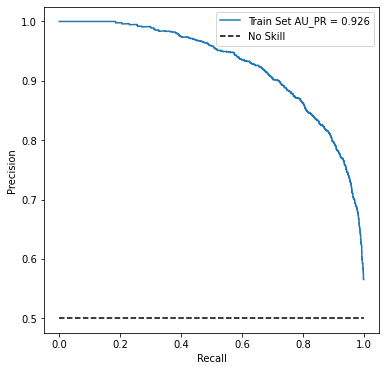

In [33]:
precision, recall, _ = precision_recall_curve(train_grouped.Label, lr_probs[:,1])
pr_thres = pd.DataFrame(data =  list(zip(precision, recall)), columns = ['prec','recall'])
auc_score = auc(recall, precision)

#plot PR curve
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall, precision, label='Train Set AU_PR = {:.3f}'.format(auc_score))
noskill = len(train_grouped[train_grouped['Label']==1]) / len(train_grouped['Label'])
ax.plot([0, 1], [noskill, noskill], 'k--', label='No Skill')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='upper right');

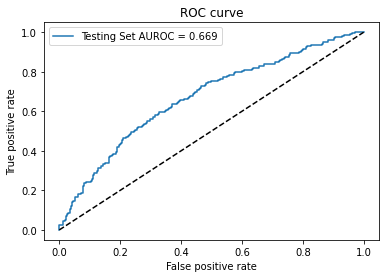

In [179]:
lr_probs = lr_model.predict_proba(list(test_grouped.l_diff_pad))
lr_fpr, lr_tpr, _ = roc_curve(test_grouped.Label, lr_probs[:,1])
auc_score = auc(lr_fpr, lr_tpr)
plt.plot(lr_fpr, lr_tpr, label='Testing Set AUROC = {:.3f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Recall at Precision of 80 is 0.0241


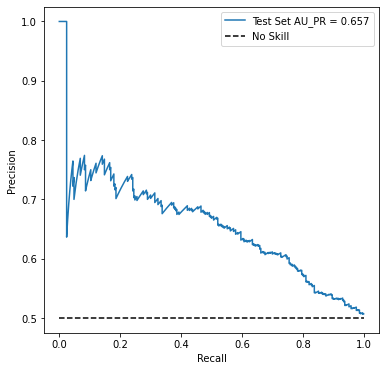

In [184]:
precision, recall, _ = precision_recall_curve(test_grouped.Label, lr_probs[:,1])
pr_thres = pd.DataFrame(data =  list(zip(precision, recall)), columns = ['prec','recall'])
auc_score = auc(recall, precision)

#plot PR curve
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall, precision, label='Test Set AU_PR = {:.3f}'.format(auc_score))
noskill = len(test_grouped[test_grouped['Label']==1]) / len(test_grouped['Label'])
ax.plot([0, 1], [noskill, noskill], 'k--', label='No Skill')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='upper right');

temp = pr_thres[pr_thres['prec'] > 0.7999999].reset_index()

rp80 = 0
if temp.size == 0:
    print('Test Sample too small or precision never reached .80!')
else:
    rp80 = temp.iloc[0].recall
    print('Recall at Precision of 80 is {:.4f}'.format(rp80))

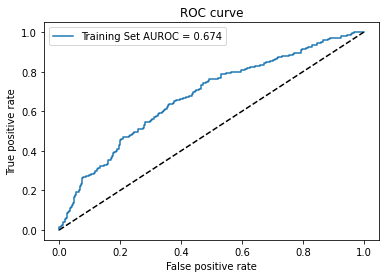

In [185]:
lr_model = LogisticRegression(random_state=100, C = 100).fit(list(train_grouped.p_diff_pad), train_grouped.Label)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = lr_model.predict_proba(list(test_grouped.p_diff_pad))
lr_fpr, lr_tpr, _ = roc_curve(test_grouped.Label, lr_probs[:,1])
auc_score = auc(lr_fpr, lr_tpr)
plt.plot(lr_fpr, lr_tpr, label='Training Set AUROC = {:.3f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Recall at Precision of 80 is 0.2655


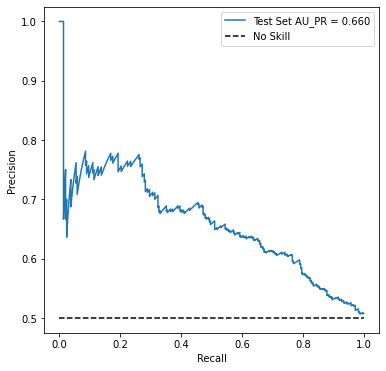

In [189]:
precision, recall, _ = precision_recall_curve(test_grouped.Label, lr_probs[:,1])
pr_thres = pd.DataFrame(data =  list(zip(precision, recall)), columns = ['prec','recall'])
auc_score = auc(recall, precision)

#plot PR curve
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall, precision, label='Test Set AU_PR = {:.3f}'.format(auc_score))
noskill = len(test_grouped[test_grouped['Label']==1]) / len(test_grouped['Label'])
ax.plot([0, 1], [noskill, noskill], 'k--', label='No Skill')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='upper right');

temp = pr_thres[pr_thres['prec'] > 0.7699999].reset_index()

rp80 = 0
if temp.size == 0:
    print('Test Sample too small or precision never reached .80!')
else:
    rp80 = temp.iloc[0].recall
    print('Recall at Precision of 80 is {:.4f}'.format(rp80))

## Tensorflow Base Model

In [37]:
import tensorflow as tf
#from tensorflow import keras
import keras
from keras.models import Sequential
from keras.layers import Dense

In [38]:
X_train = np.asarray(list(train_grouped.l_diff_pad)).astype('float32')
X_train_p = np.asarray(list(train_grouped.p_diff_pad)).astype('float32')
y_train = np.asarray(train_grouped.Label).astype('float32').reshape((-1,1))

X_test = np.asarray(list(test_grouped.l_diff_pad)).astype('float32')
X_test_p = np.asarray(list(test_grouped.p_diff_pad)).astype('float32')
y_test = np.asarray(test_grouped.Label).astype('float32').reshape((-1,1))

In [48]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
  model = Sequential()
  model.add(Dense(10, input_dim=10, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 40, 80, 100]
epochs = [10, 20, 30, 50]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(batch_size=batch_size, epochs=epochs) #, optimizer = optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.840589 using {'batch_size': 10, 'epochs': 30}
0.836961 (0.007097) with: {'batch_size': 10, 'epochs': 10}
0.838455 (0.006236) with: {'batch_size': 10, 'epochs': 20}
0.840589 (0.006855) with: {'batch_size': 10, 'epochs': 30}
0.834614 (0.002176) with: {'batch_size': 10, 'epochs': 50}
0.835041 (0.004567) with: {'batch_size': 40, 'epochs': 10}
0.837601 (0.006961) with: {'batch_size': 40, 'epochs': 20}
0.834614 (0.007020) with: {'batch_size': 40, 'epochs': 30}
0.833120 (0.006103) with: {'batch_size': 40, 'epochs': 50}
0.829705 (0.001045) with: {'batch_size': 80, 'epochs': 10}
0.836321 (0.009728) with: {'batch_size': 80, 'epochs': 20}
0.835894 (0.004857) with: {'batch_size': 80, 'epochs': 30}
0.836961 (0.007472) with: {'batch_size': 80, 'epochs': 50}
0.834187 (0.006550) with: {'batch_size': 100, 'epochs': 10}
0.836748 (0.007243) with: {'batch_size': 100, 'epochs': 20}
0.837175 (0.010327) with: {'batch_size': 100, 'epochs': 30}
0.837175 (0.007399) with: {'batch_size': 100, 'epochs': 50

In [50]:
nn_test_acc = []
nn_test_auc = []
i = 0
while i < 10:
  model = Sequential()
  model.add(Dense(10, input_dim=10, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
  model.fit(X_train, y_train, epochs=30, verbose = 0, validation_split = 0.15, batch_size = 10)
  _, accuracy, AUC = model.evaluate(X_test, y_test, verbose = 1)
  nn_test_acc.append(accuracy)
  nn_test_auc.append(AUC)
  i = i+ 1
print('Accuracy: %.4f' % (np.mean(nn_test_acc)*100))
print('AUC: %.3f' % np.mean(nn_test_auc))

19/19 [==============================] - 0s 3ms/step - loss: 1.0913 - accuracy: 0.6259 - auc: 0.6607
Accuracy: 63.3966
AUC: 0.666


In [ ]:
nn_test_acc = []
nn_test_auc = []
i = 0
while i < 10:
  model = Sequential()
  model.add(Dense(10, input_dim=10, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
  model.fit(X_train_p, y_train, epochs=50, verbose = 0, validation_split=0.15)
  _, accuracy, AUC = model.evaluate(X_test_p, y_test, verbose = 1)
  nn_test_acc.append(accuracy)
  nn_test_auc.append(AUC)
  i = i+ 1
print('Accuracy: %.4f' % (np.mean(nn_test_acc)*100))
print('AUC: %.3f' % np.mean(nn_test_auc))

19/19 [==============================] - 0s 3ms/step - loss: 0.9262 - accuracy: 0.6293 - auc: 0.6729
Accuracy: 63.1724
AUC: 0.672


In [ ]:
# From the above, we see that keeping the logits may not be as good as using the direct probabilities

## CNN Pooling

In [51]:
#For additional types of NNs, it is necessary to add an extra dimension, so we reshape
X_train_reshape = np.reshape(X_train, (4686,10,1))
X_train_p_reshape = np.reshape(X_train_p, (4686,10,1))

X_test_reshape = np.reshape(X_test, (580,10,1))
X_test_p_reshape = np.reshape(X_test_p, (580,10,1))

In [56]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
  model = Sequential()
  model.add(Conv1D(32, 4, padding='same', activation="relu")) #, input_shape=(4686,10)))
  model.add(Dense(8, activation="relu"))
  model.add(MaxPooling1D(pool_size=2, strides=1))
  model.add(Dropout(0.2))
  model.add(Conv1D(8, 4, padding='same', activation="relu")) #, input_shape=(4686,10)))
  model.add(Dense(8, activation="relu"))
  model.add(MaxPooling1D(pool_size=2, strides=1))
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
  return model
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 30, 50, 100]
epochs = [10, 20, 30, 50]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(batch_size=batch_size, epochs=epochs) #, optimizer = optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_p_reshape, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.841229 using {'batch_size': 50, 'epochs': 10}
0.839735 (0.004857) with: {'batch_size': 10, 'epochs': 10}
0.838242 (0.004225) with: {'batch_size': 10, 'epochs': 20}
0.840376 (0.004941) with: {'batch_size': 10, 'epochs': 30}
0.838028 (0.006338) with: {'batch_size': 10, 'epochs': 50}
0.837388 (0.005041) with: {'batch_size': 20, 'epochs': 10}
0.834400 (0.003558) with: {'batch_size': 20, 'epochs': 20}
0.838882 (0.006536) with: {'batch_size': 20, 'epochs': 30}
0.836748 (0.001885) with: {'batch_size': 20, 'epochs': 50}
0.840802 (0.003018) with: {'batch_size': 30, 'epochs': 10}
0.838028 (0.002395) with: {'batch_size': 30, 'epochs': 20}
0.837388 (0.005041) with: {'batch_size': 30, 'epochs': 30}
0.838028 (0.005305) with: {'batch_size': 30, 'epochs': 50}
0.841229 (0.005148) with: {'batch_size': 50, 'epochs': 10}
0.840376 (0.005236) with: {'batch_size': 50, 'epochs': 20}
0.837601 (0.002879) with: {'batch_size': 50, 'epochs': 30}
0.835894 (0.004714) with: {'batch_size': 50, 'epochs': 50}
0.

In [57]:
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout

cnn_test_acc = []
cnn_test_auc = []
i = 0
while i < 10:
  model = Sequential()
  model.add(Conv1D(32, 4, padding='same', activation="relu")) #, input_shape=(4686,10)))
  model.add(Dense(8, activation="relu"))
  model.add(MaxPooling1D(pool_size=2, strides=1))
  model.add(Dropout(0.2))
  model.add(Conv1D(8, 4, padding='same', activation="relu")) #, input_shape=(4686,10)))
  model.add(Dense(8, activation="relu"))
  model.add(MaxPooling1D(pool_size=2, strides=1))
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
  model.fit(X_train_p_reshape, y_train, epochs=10, verbose = 0, validation_split = 0.15, batch_size = 50)
  _, accuracy, AUC = model.evaluate(X_test_p_reshape, y_test, verbose = 1)
  cnn_test_acc.append(accuracy)
  cnn_test_auc.append(AUC)
  i = i+ 1
print('Accuracy: %.4f' % (np.mean(cnn_test_acc)*100))
print('AUC: %.3f' % np.mean(cnn_test_auc))

19/19 [==============================] - 0s 4ms/step - loss: 0.8963 - accuracy: 0.6310 - auc: 0.6673
Accuracy: 63.7586
AUC: 0.671


## LSTM Model

In [154]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
  model = Sequential()
  model.add(LSTM(units=10, activation='relu'))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
  return model
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 30, 50, 100]
epochs = [10, 20, 30, 50]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(batch_size=batch_size, epochs=epochs) #, optimizer = optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_p_reshape, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.842936 using {'batch_size': 50, 'epochs': 50}
0.840162 (0.005288) with: {'batch_size': 10, 'epochs': 10}
0.838455 (0.005288) with: {'batch_size': 10, 'epochs': 20}
0.835467 (0.008412) with: {'batch_size': 10, 'epochs': 30}
0.839949 (0.006550) with: {'batch_size': 10, 'epochs': 50}
0.836108 (0.007700) with: {'batch_size': 20, 'epochs': 10}
0.836534 (0.006059) with: {'batch_size': 20, 'epochs': 20}
0.838668 (0.004646) with: {'batch_size': 20, 'epochs': 30}
0.839522 (0.007847) with: {'batch_size': 20, 'epochs': 50}
0.836108 (0.004557) with: {'batch_size': 30, 'epochs': 10}
0.836108 (0.008165) with: {'batch_size': 30, 'epochs': 20}
0.838455 (0.004567) with: {'batch_size': 30, 'epochs': 30}
0.840589 (0.006163) with: {'batch_size': 30, 'epochs': 50}
0.837388 (0.004149) with: {'batch_size': 50, 'epochs': 10}
0.838882 (0.006822) with: {'batch_size': 50, 'epochs': 20}
0.835894 (0.005638) with: {'batch_size': 50, 'epochs': 30}
0.842936 (0.005023) with: {'batch_size': 50, 'epochs': 50}
0.

In [155]:
from keras.layers import LSTM
tf.get_logger().setLevel('ERROR')

lstm_test_acc = []
lstm_test_auc = []
i = 0
while i < 10:
  model = Sequential()
  model.add(LSTM(units=10, activation='relu'))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
  model.fit(X_train_p_reshape, y_train, epochs=50, verbose = 0, batch_size = 50)
  _, accuracy, AUC = model.evaluate(X_test_p_reshape, y_test, verbose = 1)
  lstm_test_acc.append(accuracy)
  lstm_test_auc.append(AUC)
  i = i + 1
print('Accuracy: %.4f' % np.mean(lstm_test_acc))
print('AUC: %.3f' % np.mean(lstm_test_auc))

19/19 [==============================] - 0s 4ms/step - loss: 0.9310 - accuracy: 0.6310 - auc: 0.6772
Accuracy: 0.6371
AUC: 0.674


# Adjusting Weighting of Later Values (DONE IN THE ORIGINAL FOUR EPOCH NOTEBOOK TO SHOW IT DOES NOT IMPROVE)

We can take a look to see if the length of the note affects the prediction. After finding the means and standard deviations of readmitted vs non-readmitted, we can see the mean is slightly higher for the readmitted data, but is in no way statistically significant since it is a fraction of a standard deviation higher. We can still change the values of our padding to see if the accuracy increases at all.

In [ ]:
df_data = pd.read_pickle('/content/drive/MyDrive/w266: NLP Project/pickle_files/df_less_3_by_hour.pkl')
data_grouped = df_data.groupby('ID').agg({'Label':{'count','mean'}}).reset_index()['Label']

In [ ]:
data_grouped[data_grouped['mean'] == 0]['count'].describe()

count    41793.000000
mean        10.011485
std         13.978180
min          1.000000
25%          3.000000
50%          6.000000
75%          9.000000
max        176.000000
Name: count, dtype: float64

In [ ]:
data_grouped[data_grouped['mean'] == 1]['count'].describe()

count    2930.000000
mean       12.419113
std        17.927563
min         1.000000
25%         3.000000
50%         6.000000
75%        11.000000
max       130.000000
Name: count, dtype: float64

In [ ]:
import ast
def replace_pad(df, l_val, p_val):
  l_val_str1 = ' %0.2f,' % l_val
  l_val_str2 = ' %0.2f]' % l_val
  p_val_str1 = ' %0.2f,' % p_val
  p_val_str2 = ' %0.2f]' % p_val
  df['l_adj'] = df['l_diff_pad'].astype(str).str.replace(' 0,', l_val_str1).replace(' 0]', l_val_str2).apply(ast.literal_eval)
  df['p_adj'] = df['p_diff_pad'].astype(str).str.replace(' 0,', p_val_str1).replace(' 0]', p_val_str2).apply(ast.literal_eval)

replace_pad(train_grouped, 0.2, 0.1)
replace_pad(test_grouped, 0.2, 0.1)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
grid={"C":np.append(np.logspace(-3,3,7),np.linspace(2e-2, 9e-2, 8)), "penalty":["l2"], "max_iter":[50,100,300,500]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(list(train_grouped.l_adj), train_grouped.Label)
print("tuned hyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hyerparameters :(best parameters)  {'C': 0.03, 'max_iter': 50, 'penalty': 'l2'}
accuracy : 0.8333342445282744


In [ ]:
import warnings
warnings.filterwarnings("ignore")
grid={"C":np.append(np.logspace(-3,3,7),np.linspace(2e-2, 9e-2, 8)), "penalty":["l2"], "max_iter":[50,100,300,500]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(list(train_grouped.p_adj), train_grouped.Label)
print("tuned hyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hyerparameters :(best parameters)  {'C': 1.0, 'max_iter': 50, 'penalty': 'l2'}
accuracy : 0.8292771490532684


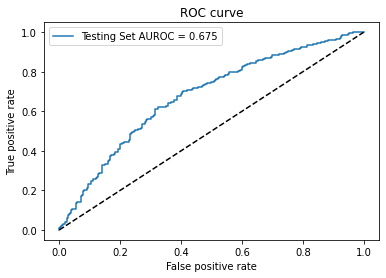

In [ ]:
lr_model = LogisticRegression(random_state=0, C = 0.03).fit(list(train_grouped.l_adj), train_grouped.Label)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = lr_model.predict_proba(list(test_grouped.l_adj))
lr_fpr, lr_tpr, _ = roc_curve(test_grouped.Label, lr_probs[:,1])
auc_score = auc(lr_fpr, lr_tpr)
plt.plot(lr_fpr, lr_tpr, label='Testing Set AUROC = {:.3f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
X_train = np.asarray(list(train_grouped.l_adj)).astype('float32')
X_train_p = np.asarray(list(train_grouped.p_adj)).astype('float32')
y_train = np.asarray(train_grouped.Label).astype('float32').reshape((-1,1))

X_test = np.asarray(list(test_grouped.l_adj)).astype('float32')
X_test_p = np.asarray(list(test_grouped.p_adj)).astype('float32')
y_test = np.asarray(test_grouped.Label).astype('float32').reshape((-1,1))

In [ ]:
nn_test_acc = []
nn_test_auc = []
i = 0
while i < 10:
  model = Sequential()
  model.add(Dense(10, input_dim=10, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
  model.fit(X_train, y_train, epochs=50, verbose = 0, validation_split = 0.15)
  _, accuracy, AUC = model.evaluate(X_test, y_test, verbose = 1)
  nn_test_acc.append(accuracy)
  nn_test_auc.append(AUC)
  i = i+ 1
print('Accuracy: %.4f' % (np.mean(nn_test_acc)*100))
print('AUC: %.3f' % np.mean(nn_test_auc))

19/19 [==============================] - 0s 3ms/step - loss: 1.1109 - accuracy: 0.6345 - auc: 0.6691
Accuracy: 63.1207
AUC: 0.665


# Adjusting Label Ratio to True Values

With the above inspection into the original data, we would expect a base accuracy of about 0.935 if we just labeled everything as non-readmissions. Because we already under-sampled to get the train and test data, it would further cut the test data to near half, giving a very small sample. However, over-sampling the already under-sampled data would introduce bias. We can try both as a test.

In [201]:
l_diff_padding = np.load('drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/l_diff_pad_test_unbalance.npy', allow_pickle= True)
p_diff_padding = np.load('drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/p_diff_pad_test_unbalance.npy', allow_pickle= True)
test_unbalanced_grouped = pd.read_csv('drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/df_test_unbalance_grouped.csv')
test_unbalanced_grouped['l_diff_pad'] = l_diff_padding
test_unbalanced_grouped['p_diff_pad'] = p_diff_padding

In [253]:
df_test_unbalance.Label[test_unbalance_indices]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
10902    0.0
10903    0.0
10904    1.0
10905    1.0
10906    1.0
Name: Label, Length: 10907, dtype: float64

In [63]:
df_test_unbalance = pd.read_csv('/content/drive/MyDrive/w266: NLP Project/data/3days_by_hour/unbalanced_test_reduced.csv')
test_unbalance_input_ids = np.load('/content/drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/test_unbalance_input_ids.npy')
test_unbalance_true_labels = np.load('/content/drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/test_unbalance_true_labels.npy', allow_pickle=True)
test_unbalance_logit_array = np.load('/content/drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/test_unbalance_logit_array.npy', allow_pickle=True)
test_unbalance_finding_input_id = np.load('/content/drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/test_unbalance_finding_input_id.npy', allow_pickle=True)

test_unbalance_true_labels_big = np.array(list(chain.from_iterable(test_unbalance_true_labels)))
test_unbalance_logit_array_big = np.array(list(chain.from_iterable(test_unbalance_logit_array)))
test_unbalance_inputs_big = np.array(list(chain.from_iterable(test_unbalance_finding_input_id)))

test_unbalance_input_ids = test_unbalance_input_ids.tolist()
test_unbalance_inputs_big = test_unbalance_inputs_big.tolist()

test_unbalance_indices = []
for i in range(0,len(test_unbalance_input_ids)):
  test_unbalance_indices.append(test_unbalance_input_ids.index(test_unbalance_inputs_big[i]))

test_unbalance_results = pd.DataFrame({'ID': df_test_unbalance.ID[test_unbalance_indices], 'logits': test_unbalance_logit_array_big.tolist(), 'Label': df_test_unbalance.Label[test_unbalance_indices]})
test_unbalance_results['logit_diff'] = [x[1] - x[0] for x in test_unbalance_results.logits]
test_unbalance_results['prob_diff'] = [nn.sigmoid(x[1]).numpy() - nn.sigmoid(x[0]).numpy() for x in test_unbalance_results.logits]
test_unbalance_results = test_unbalance_results.sort_index()

test_unbalance_grouped = test_unbalance_results.groupby('ID').agg({'Label': 'mean', 'logit_diff': lambda x: list(x), 'prob_diff': lambda x: list(x)})
test_unbalance_grouped.reset_index(level=0, inplace=True)

p_diff_pad = []
for i in test_unbalance_grouped.prob_diff:
  if len(i) >= 10:
    p_diff_pad.append(i[0:5] + i[-5:])
  else:
    x = len(i)
    y = list(i)
    while x < 10:
      y.append(0)
      x = x + 1
    p_diff_pad.append(y)

l_diff_pad = []
for i in test_unbalance_grouped.logit_diff:
  if len(i) >= 10:
    l_diff_pad.append(i[0:5] + i[-5:])
  else:
    x = len(i)
    y = list(i)
    while x < 10:
      y.append(0)
      x = x + 1
    l_diff_pad.append(y)

test_unbalance_grouped['l_diff_pad'] = l_diff_pad
test_unbalance_grouped['p_diff_pad'] = p_diff_pad
test_unbalance_grouped.to_csv('/content/drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/df_test_unbalance_grouped.csv')
np.save('drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/l_diff_pad_test_unbalance.npy', test_unbalance_grouped.l_diff_pad)
np.save('drive/MyDrive/w266: NLP Project/Ryan folder optimize/fixed_sep/four_epoch/extra_run_2/p_diff_pad_test_unbalance.npy', test_unbalance_grouped.p_diff_pad)

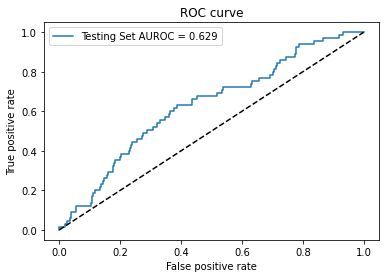

In [203]:
lr_model = LogisticRegression(random_state=0, C = 1).fit(list(train_grouped.l_diff_pad), train_grouped.Label)
lr_probs = lr_model.predict_proba(list(test_unbalance_grouped.l_diff_pad))
lr_fpr, lr_tpr, _ = roc_curve(test_unbalance_grouped.Label, lr_probs[:,1])
auc_score = auc(lr_fpr, lr_tpr)
plt.plot(lr_fpr, lr_tpr, label='Testing Set AUROC = {:.3f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [257]:
X_train = np.asarray(list(train_grouped.l_diff_pad)).astype('float32')
X_train_p = np.asarray(list(train_grouped.p_diff_pad)).astype('float32')
y_train = np.asarray(train_grouped.Label).astype('float32').reshape((-1,1))

X_test_unb = np.asarray(list(test_unbalance_grouped.l_diff_pad)).astype('float32')
X_test_unb_p = np.asarray(list(test_unbalance_grouped.p_diff_pad)).astype('float32')
y_test_unb = np.asarray(test_unbalance_grouped.Label).astype('float32').reshape((-1,1))

X_train_reshape = np.reshape(X_train, (4686,10,1))
X_train_p_reshape = np.reshape(X_train_p, (4686,10,1))

X_test_unb_reshape = np.reshape(X_test_unb, (1065,10,1))
X_test_unb_p_reshape = np.reshape(X_test_unb_p, (1065,10,1))

In [258]:
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout

cnn_test_acc = []
cnn_test_auc = []
i = 0
while i < 10:
  model = Sequential()
  model.add(Conv1D(32, 4, padding='same', activation="relu")) #, input_shape=(4686,10)))
  model.add(Dense(8, activation="relu"))
  model.add(MaxPooling1D(pool_size=2, strides=1))
  model.add(Dropout(0.2))
  model.add(Conv1D(8, 4, padding='same', activation="relu")) #, input_shape=(4686,10)))
  model.add(Dense(8, activation="relu"))
  model.add(MaxPooling1D(pool_size=2, strides=1))
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
  model.fit(X_train_p_reshape, y_train, epochs=10, verbose = 0, validation_split = 0.15, batch_size = 50)
  _, accuracy, AUC = model.evaluate(X_test_unb_p_reshape, y_test_unb, verbose = 1)
  cnn_test_acc.append(accuracy)
  cnn_test_auc.append(AUC)
  i = i+ 1
print('Accuracy: %.4f' % (np.mean(cnn_test_acc)*100))
print('AUC: %.3f' % np.mean(cnn_test_auc))

34/34 [==============================] - 0s 4ms/step - loss: 0.8215 - accuracy: 0.6413 - auc: 0.6292
Accuracy: 63.3991
AUC: 0.628


Trying to nudge the probability cutoff from 0.5 to some other number

In [235]:
train_grouped['prob_mean'] = pd.DataFrame([ast.literal_eval(train_grouped['prob_diff'][i]) for i in range(0,len(train_grouped['prob_diff']))]).mean(1)

In [251]:
import ast
np.mean([train_grouped.Label == [1 if x > 0.9 else 0 for x in train_grouped['prob_mean']]])

0.5021340162185233

In [265]:
np.mean([test_unbalance_grouped.Label == [1 if x > 0.9 else 0 for x in test_unbalance_grouped['prob_mean']]])
1 - np.mean(test_unbalance_grouped.Label)

0.9389671361502347

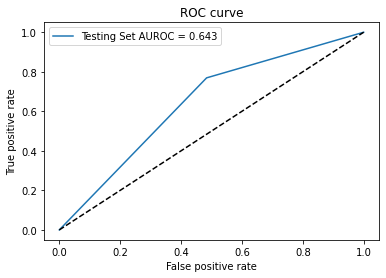

In [151]:
mean_fpr, mean_tpr, _ = roc_curve(test_unbalance_grouped.Label, [1 if x > -0.14 else 0 for x in test_unbalance_grouped['prob_mean']])
auc_score = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, label='Testing Set AUROC = {:.3f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#[1 if x > 0 else 0 for x in test_unbalance_grouped['prob_mean']]